In [1]:
import pandas as pd
from typing import List, Dict
import os
import gc

# ========================================
# Configuration & Output Paths
# ========================================
OUTPUT_DIR = './outputs'
os.makedirs(OUTPUT_DIR, exist_ok=True)

def load_all_csv_from_folder(folder_path: str) -> Dict[str, pd.DataFrame]:
    """
    Load all CSV files from the specified folder into a dictionary of pandas DataFrames.
    Uses memory-efficient loading with appropriate dtypes.
    """
    dataframes = {}
    
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            # Load with low_memory=False to avoid mixed type warnings
            df = pd.read_csv(file_path, low_memory=False)
            # strip the .csv extension for the key
            key = filename[:-4]
            dataframes[key] = df
    
    return dataframes

def clear_memory(*args):
    """Clear specified variables and run garbage collection."""
    for var in args:
        del var
    gc.collect()
    
def get_memory_usage_mb():
    """Get current memory usage in MB."""
    import psutil
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024

print(f"Output directory: {os.path.abspath(OUTPUT_DIR)}")

Output directory: c:\Users\20232788\Desktop\Year3\language_and_ai\jupyter_notebooks\outputs


In [2]:
folder_path = '../datasets/'

# Load data
dataframes_dict = load_all_csv_from_folder(folder_path)

# Show memory usage after loading
try:
    print(f"Memory usage after loading: {get_memory_usage_mb():.1f} MB")
except:
    pass  # psutil not available

Memory usage after loading: 7649.1 MB


In [3]:
# print all heades of dataframes
for name, df in dataframes_dict.items():
    print(f"DataFrame: {name}")
    print(df.head())
    print("\n")

DataFrame: birth_year
    auhtor_ID                                               post  birth_year
0  t2_rnjzutp  Good on you for being responsible! I know self...        2001
1  t2_rnjzutp  must go to the grocery store with their child,...        2001
2  t2_rnjzutp  things on her videos, and YouTube took the vid...        2001
3  t2_rnjzutp  their app. There's also a program called SYNC ...        2001
4  t2_rnjzutp  side. If the cops don't take your side, you'll...        2001


DataFrame: extrovert_introvert
     auhtor_ID                                               post  extrovert
0  t2_2hrxxs28  I have a question, if you have no doctor, how'...          0
1  t2_2hrxxs28  butt to have Covid + your cycle. I'm not sure ...          0
2  t2_2hrxxs28  through different doctors. My situation sucks ...          0
3   t2_4pxpgwz  i thought it was about the pebbleyeet guy the ...          0
4   t2_4pxpgwz  …i always end up voting wrong even as crewmate...          0


DataFrame: feeling_

In [4]:
# print length of each dataframe
for name, df in dataframes_dict.items():
    print(f"DataFrame: {name}, Length: {len(df)}")  

DataFrame: birth_year, Length: 41873
DataFrame: extrovert_introvert, Length: 40452
DataFrame: feeling_thinking, Length: 39600
DataFrame: gender, Length: 44635
DataFrame: judging_perceiving, Length: 41365
DataFrame: nationality, Length: 82616
DataFrame: political_leaning, Length: 57231
DataFrame: sensing_intuitive, Length: 41839


In [5]:
from itertools import combinations
import numpy as np
import math

# normalize column names and fix common misspelling once
for name, df in dataframes_dict.items():
    df.columns = df.columns.str.strip()  # remove accidental spaces
    if 'auhtor_ID' in df.columns and 'author_ID' not in df.columns:
        df.rename(columns={'auhtor_ID': 'author_ID'}, inplace=True)

merged_dfs = {}

def _initials(name: str) -> str:
    parts = str(name).split('_')
    return '_'.join(p[0] for p in parts if p)

# create merged dataframes (inner join on author_ID)
for (name1, df1), (name2, df2) in combinations(dataframes_dict.items(), 2):
    if 'author_ID' in df1.columns and 'author_ID' in df2.columns:
        merged_df = pd.merge(df1, df2, on='author_ID', how='inner')
        key = f"{_initials(name1)}+{_initials(name2)}"
        merged_dfs[key] = merged_df

# Helper to keep unique values preserving first-seen order (treat NaN specially)
# and avoid ambiguity when checking arrays/lists

def _is_scalar_na(x):
    """Return True if x is a scalar NA; avoid calling pd.isna on list/array types."""
    if isinstance(x, (list, tuple, set, np.ndarray, pd.Series)):
        return False
    try:
        return pd.isna(x)
    except Exception:
        return False


def _normalize_for_hash(x):
    """Normalize values to a hashable representation for membership tests."""
    if isinstance(x, (list, tuple, set, np.ndarray, pd.Series)):
        try:
            # Convert to tuple for nested list/array types
            if hasattr(x, 'tolist'):
                return tuple(x.tolist())
            return tuple(x)
        except Exception:
            return str(x)
    if _is_scalar_na(x):
        return 'NA'
    return x


def _unique_preserve_order(seq):
    seen = []
    seen_hashes = set()
    for v in seq:
        norm = _normalize_for_hash(v)
        if norm == 'NA':
            if norm not in seen_hashes:
                seen_hashes.add(norm)
                seen.append(np.nan)
        else:
            if norm not in seen_hashes:
                seen_hashes.add(norm)
                seen.append(v)
    return seen

# Collapse rows so author_ID is unique; for each other column keep single value if identical,
# otherwise keep list of unique values (preserving order)
def _collapse_duplicate_authors(df: pd.DataFrame) -> pd.DataFrame:
    if 'author_ID' not in df.columns:
        return df.copy()
    def agg_col(s: pd.Series):
        vals = s.tolist()
        uniq = _unique_preserve_order(vals)
        if len(uniq) == 0:
            return np.nan
        if len(uniq) == 1:
            return uniq[0]
        return uniq
    return df.groupby('author_ID', as_index=False).agg(agg_col)

# Apply collapsing to all merged dataframes in-place
for key, mdf in list(merged_dfs.items()):
    merged_dfs[key] = _collapse_duplicate_authors(mdf)

# ----------------------------------------
# Merge post_x and post_y into single 'post' column
# Remove duplicates within the row-level lists (preserve order)
# Keep single string if only one unique post, or list if multiple
# ----------------------------------------
def _ensure_list_like(v):
    """Return a list of non-null items from v.
    If v is a list/tuple/ndarray/Series, iterate; if scalar, return [v] (unless NaN).
    """
    if isinstance(v, (list, tuple, set, np.ndarray, pd.Series)):
        out = []
        for item in v:
            if not _is_scalar_na(item):
                out.append(item)
        return out
    if _is_scalar_na(v):
        return []
    return [v]


def _merge_posts_row(a, b):
    parts = []
    parts.extend(_ensure_list_like(a))
    parts.extend(_ensure_list_like(b))
    # Convert non-string items to string to keep consistency (texts expected)
    parts = [p if isinstance(p, str) else str(p) for p in parts]
    uniq = _unique_preserve_order(parts)
    if len(uniq) == 0:
        return np.nan
    if len(uniq) == 1:
        return uniq[0]
    return uniq

for key, mdf in list(merged_dfs.items()):
    has_post_x = 'post_x' in mdf.columns
    has_post_y = 'post_y' in mdf.columns
    
    if has_post_x or has_post_y:
        # Use .values for faster iteration (avoids Series overhead)
        a_vals = mdf['post_x'].values if has_post_x else np.full(len(mdf), np.nan)
        b_vals = mdf['post_y'].values if has_post_y else np.full(len(mdf), np.nan)
        
        # Merge posts
        merged_posts = [_merge_posts_row(a, b) for a, b in zip(a_vals, b_vals)]
        mdf['post'] = merged_posts
        
        # Drop original columns in one operation
        drop_cols = [c for c in ['post_x', 'post_y'] if c in mdf.columns]
        if drop_cols:
            mdf.drop(columns=drop_cols, inplace=True)
        
        # Update back
        merged_dfs[key] = mdf

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import combinations

# Set style for all plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Collect basic stats before printing
stats_summary = {
    'n_original': len(dataframes_dict),
    'n_merged': len(merged_dfs),
    'original_rows': {name: len(df) for name, df in dataframes_dict.items()},
    'merged_rows': {name: len(df) for name, df in merged_dfs.items()}
}

print(f"Number of original dataframes: {stats_summary['n_original']}")
print(f"Number of merged dataframe pairs: {stats_summary['n_merged']}")
print(f"\nOriginal DataFrames:")
for name, rows in stats_summary['original_rows'].items():
    print(f"  - {name}: {rows:,} rows")
print(f"\nMerged DataFrames:")
for name, rows in stats_summary['merged_rows'].items():
    print(f"  - {name}: {rows:,} rows")

# Save stats to JSON
import json
with open(f'{OUTPUT_DIR}/merge_stats_summary.json', 'w') as f:
    json.dump(stats_summary, f, indent=2)
print(f"\n✓ Stats saved to {OUTPUT_DIR}/merge_stats_summary.json")

Number of original dataframes: 8
Number of merged dataframe pairs: 28

Original DataFrames:
  - birth_year: 41,873 rows
  - extrovert_introvert: 40,452 rows
  - feeling_thinking: 39,600 rows
  - gender: 44,635 rows
  - judging_perceiving: 41,365 rows
  - nationality: 82,616 rows
  - political_leaning: 57,231 rows
  - sensing_intuitive: 41,839 rows

Merged DataFrames:
  - b_y+e_i: 8 rows
  - b_y+f_t: 10 rows
  - b_y+g: 974 rows
  - b_y+j_p: 3 rows
  - b_y+n: 5 rows
  - b_y+p_l: 2 rows
  - b_y+s_i: 7 rows
  - e_i+f_t: 884 rows
  - e_i+g: 8 rows
  - e_i+j_p: 838 rows
  - e_i+n: 12 rows
  - e_i+p_l: 9 rows
  - e_i+s_i: 848 rows
  - f_t+g: 11 rows
  - f_t+j_p: 876 rows
  - f_t+n: 7 rows
  - f_t+p_l: 9 rows
  - f_t+s_i: 864 rows
  - g+j_p: 8 rows
  - g+n: 6 rows
  - g+p_l: 1 rows
  - g+s_i: 7 rows
  - j_p+n: 3 rows
  - j_p+p_l: 7 rows
  - j_p+s_i: 852 rows
  - n+p_l: 26 rows
  - n+s_i: 8 rows
  - p_l+s_i: 10 rows

✓ Stats saved to ./outputs/merge_stats_summary.json


In [7]:
# print head of merged dataframes (limited to save output space)
print("Sample of merged dataframes (first 3 rows each):\n")
for name, df in list(merged_dfs.items())[:3]:  # Only show first 3 merged dfs
    print(f"DataFrame: {name}")
    print(df.head(3))
    print("\n")

Sample of merged dataframes (first 3 rows each):

DataFrame: b_y+e_i
     author_ID  birth_year  extrovert  \
0    t2_15s5rv        1996          0   
1  t2_1agxrsxx        1996          1   
2  t2_20oc7f94        1999          0   

                                                post  
0  [Κάθε φορά που το λέω σε ξένο που είμαι απο τη...  
1  [&gt;My hands are shovels I lost it at this. O...  
2  Most women I’ve experienced found it really ho...  


DataFrame: b_y+f_t
     author_ID  birth_year  feeling  \
0    t2_15s5rv        1996        0   
1  t2_1agxrsxx        1996        0   
2  t2_20oc7f94        1999        1   

                                                post  
0  [Κάθε φορά που το λέω σε ξένο που είμαι απο τη...  
1  [&gt;My hands are shovels I lost it at this. O...  
2  Most women I’ve experienced found it really ho...  


DataFrame: b_y+g
   author_ID  birth_year  female  \
0  t2_102ysr        1997       0   
1  t2_104p6j        1982       0   
2  t2_10cfab        1

C:\Users\20232788\AppData\Local\Temp\ipykernel_19916\2177871796.py:55: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax4.boxplot(box_data, labels=['Original\nDatasets', 'Merged\nDatasets'], patch_artist=True)
C:\Users\20232788\AppData\Local\Temp\ipykernel_19916\2177871796.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


✓ Dashboard saved to ./outputs/merge_dashboard.png


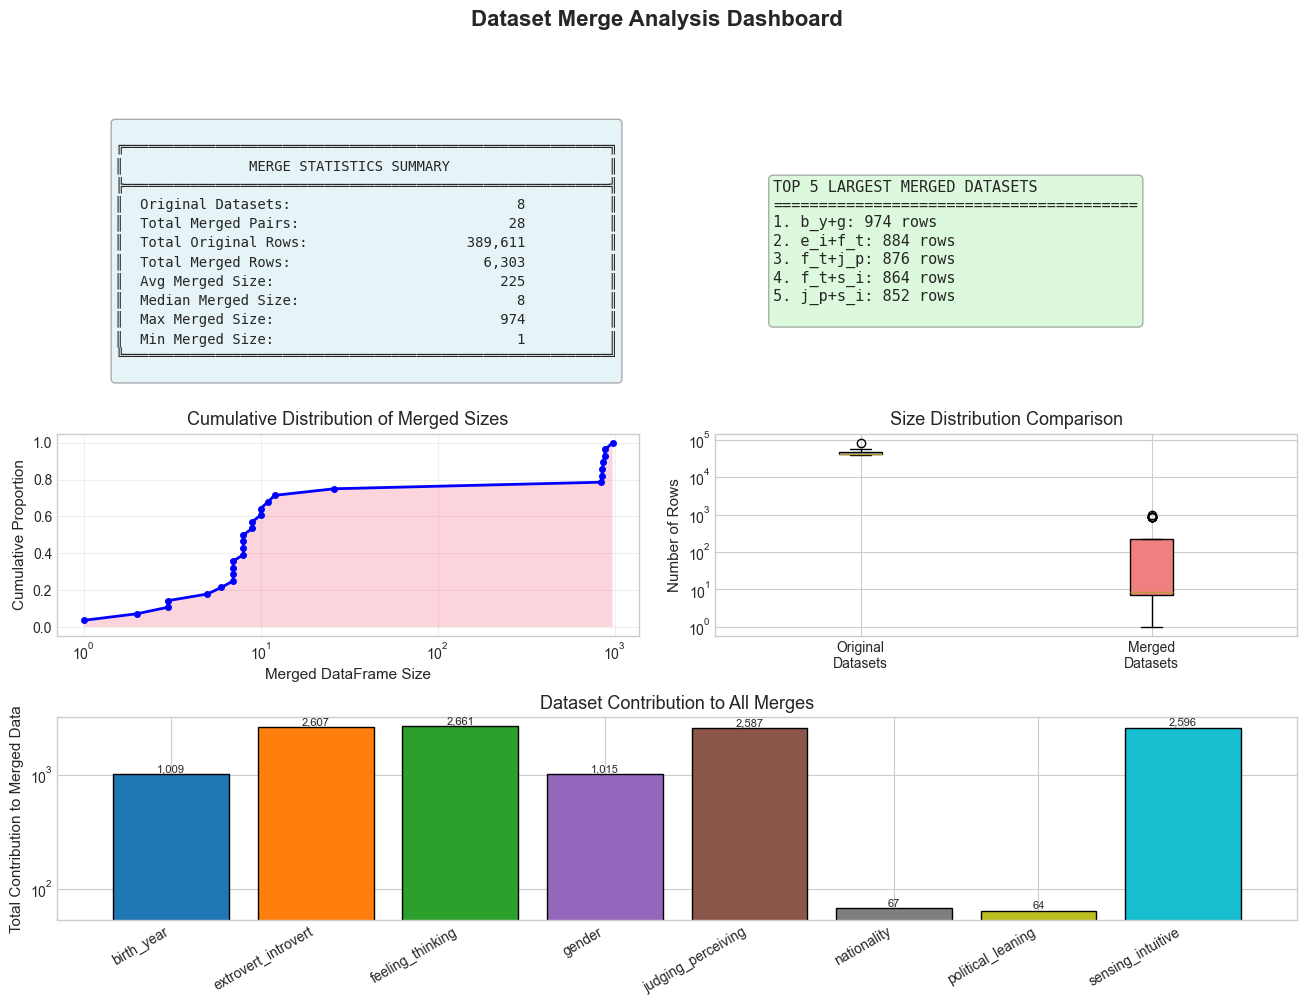

2703

In [8]:
df_names = list(dataframes_dict.keys())

fig = plt.figure(figsize=(16, 10))

# Create grid layout
gs = fig.add_gridspec(3, 4, hspace=0.4, wspace=0.3)

# Stats panel 1: Key metrics
ax1 = fig.add_subplot(gs[0, :2])
ax1.axis('off')
metrics_text = f"""
╔══════════════════════════════════════════════════════════╗
║               MERGE STATISTICS SUMMARY                   ║
╠══════════════════════════════════════════════════════════╣
║  Original Datasets:        {len(dataframes_dict):>20}          ║
║  Total Merged Pairs:       {len(merged_dfs):>20}          ║
║  Total Original Rows:      {sum(len(df) for df in dataframes_dict.values()):>20,}          ║
║  Total Merged Rows:        {sum(len(df) for df in merged_dfs.values()):>20,}          ║
║  Avg Merged Size:          {np.mean([len(df) for df in merged_dfs.values()]):>20,.0f}          ║
║  Median Merged Size:       {np.median([len(df) for df in merged_dfs.values()]):>20,.0f}          ║
║  Max Merged Size:          {max(len(df) for df in merged_dfs.values()):>20,}          ║
║  Min Merged Size:          {min(len(df) for df in merged_dfs.values()):>20,}          ║
╚══════════════════════════════════════════════════════════╝
"""
ax1.text(0.1, 0.5, metrics_text, fontsize=10, family='monospace', 
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

# Stats panel 2: Top performers
ax2 = fig.add_subplot(gs[0, 2:])
ax2.axis('off')
top_5_largest = sorted(merged_dfs.items(), key=lambda x: len(x[1]), reverse=True)[:5]
top_5_text = "TOP 5 LARGEST MERGED DATASETS\n" + "="*40 + "\n"
for i, (name, df) in enumerate(top_5_largest, 1):
    top_5_text += f"{i}. {name}: {len(df):,} rows\n"
ax2.text(0.1, 0.5, top_5_text, fontsize=11, family='monospace',
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))

# Plot: Cumulative distribution of merged sizes
ax3 = fig.add_subplot(gs[1, :2])
sorted_sizes = np.sort([len(df) for df in merged_dfs.values()])
cumulative = np.arange(1, len(sorted_sizes) + 1) / len(sorted_sizes)
ax3.plot(sorted_sizes, cumulative, 'b-', linewidth=2, marker='o', markersize=4)
ax3.fill_between(sorted_sizes, 0, cumulative, alpha=0.3)
ax3.set_xlabel('Merged DataFrame Size', fontsize=11)
ax3.set_ylabel('Cumulative Proportion', fontsize=11)
ax3.set_title('Cumulative Distribution of Merged Sizes', fontsize=13)
ax3.set_xscale('log')
ax3.grid(True, alpha=0.3)

# Plot: Box plot of original vs merged
ax4 = fig.add_subplot(gs[1, 2:])
orig_sizes = [len(df) for df in dataframes_dict.values()]
merged_sizes = [len(df) for df in merged_dfs.values()]
box_data = [orig_sizes, merged_sizes]
bp = ax4.boxplot(box_data, labels=['Original\nDatasets', 'Merged\nDatasets'], patch_artist=True)
colors = ['lightblue', 'lightcoral']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
ax4.set_ylabel('Number of Rows', fontsize=11)
ax4.set_title('Size Distribution Comparison', fontsize=13)
ax4.set_yscale('log')

# Plot: Stacked area - contribution of each original df to merges
ax5 = fig.add_subplot(gs[2, :])
contributions = {name: 0 for name in df_names}
for key, df in merged_dfs.items():
    parts = key.split('+')
    for name in df_names:
        if _initials(name) in parts:
            contributions[name] += len(df)

names = list(contributions.keys())
values = list(contributions.values())
colors = plt.cm.tab10(np.linspace(0, 1, len(names)))
bars = ax5.bar(range(len(names)), values, color=colors, edgecolor='black')
ax5.set_xticks(range(len(names)))
ax5.set_xticklabels(names, rotation=30, ha='right', fontsize=10)
ax5.set_ylabel('Total Contribution to Merged Data', fontsize=11)
ax5.set_title('Dataset Contribution to All Merges', fontsize=13)
ax5.set_yscale('log')

# Add value labels on bars
for bar, val in zip(bars, values):
    ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val:,.0f}',
             ha='center', va='bottom', fontsize=8)

plt.suptitle('Dataset Merge Analysis Dashboard', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()

# Save figure and close to free memory
plt.savefig(f'{OUTPUT_DIR}/merge_dashboard.png', dpi=150, bbox_inches='tight')
print(f"✓ Dashboard saved to {OUTPUT_DIR}/merge_dashboard.png")
plt.show()
plt.close(fig)
gc.collect()

✓ Heatmaps saved to ./outputs/merge_matrix_heatmaps.png


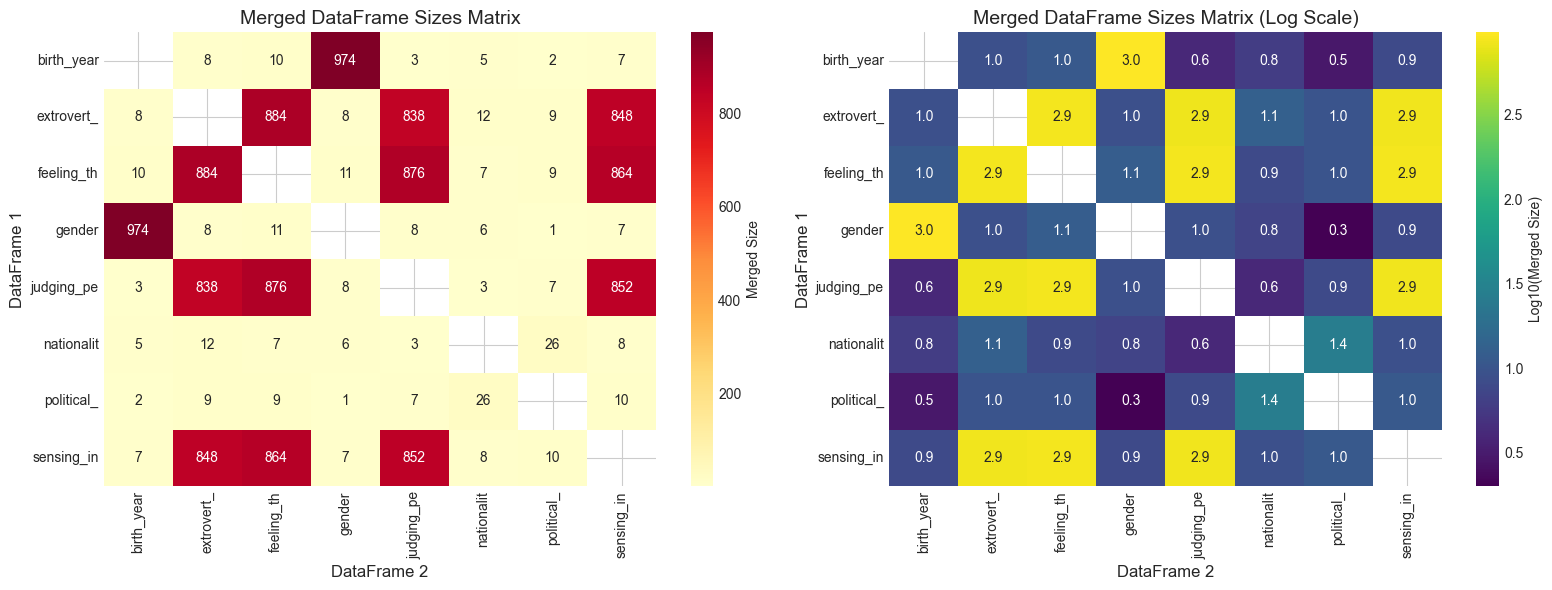

✓ Merge matrix saved to ./outputs/merge_matrix.csv


9

In [9]:
# Create a matrix of merged sizes
df_names = list(dataframes_dict.keys())
n_dfs = len(df_names)
merge_matrix = np.zeros((n_dfs, n_dfs))
merge_matrix[:] = np.nan

for i, name1 in enumerate(df_names):
    for j, name2 in enumerate(df_names):
        if i != j:
            key1 = f"{_initials(name1)}+{_initials(name2)}"
            key2 = f"{_initials(name2)}+{_initials(name1)}"
            if key1 in merged_dfs:
                merge_matrix[i, j] = len(merged_dfs[key1])
            elif key2 in merged_dfs:
                merge_matrix[i, j] = len(merged_dfs[key2])

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Linear scale heatmap
ax = axes[0]
mask = np.isnan(merge_matrix)
sns.heatmap(merge_matrix, ax=ax, annot=True, fmt='.0f', cmap='YlOrRd',
            xticklabels=[n[:10] for n in df_names], 
            yticklabels=[n[:10] for n in df_names],
            mask=np.eye(n_dfs, dtype=bool),
            cbar_kws={'label': 'Merged Size'})
ax.set_title('Merged DataFrame Sizes Matrix', fontsize=14)
ax.set_xlabel('DataFrame 2', fontsize=12)
ax.set_ylabel('DataFrame 1', fontsize=12)

# Log scale heatmap
ax = axes[1]
log_matrix = np.log10(merge_matrix + 1)
sns.heatmap(log_matrix, ax=ax, annot=True, fmt='.1f', cmap='viridis',
            xticklabels=[n[:10] for n in df_names], 
            yticklabels=[n[:10] for n in df_names],
            mask=np.eye(n_dfs, dtype=bool),
            cbar_kws={'label': 'Log10(Merged Size)'})
ax.set_title('Merged DataFrame Sizes Matrix (Log Scale)', fontsize=14)
ax.set_xlabel('DataFrame 2', fontsize=12)
ax.set_ylabel('DataFrame 1', fontsize=12)

plt.tight_layout()

# Save and close
plt.savefig(f'{OUTPUT_DIR}/merge_matrix_heatmaps.png', dpi=150, bbox_inches='tight')
print(f"✓ Heatmaps saved to {OUTPUT_DIR}/merge_matrix_heatmaps.png")
plt.show()
plt.close(fig)

# Save merge matrix as CSV
merge_matrix_df = pd.DataFrame(merge_matrix, index=df_names, columns=df_names)
merge_matrix_df.to_csv(f'{OUTPUT_DIR}/merge_matrix.csv')
print(f"✓ Merge matrix saved to {OUTPUT_DIR}/merge_matrix.csv")

# Clear temporary variables
del merge_matrix, log_matrix, merge_matrix_df
gc.collect()

In [10]:
import plotly.graph_objects as go

# Create a network visualization showing relationships between datasets
df_names = list(dataframes_dict.keys())
n_dfs = len(df_names)

# Calculate positions in a circle
angles = np.linspace(0, 2*np.pi, n_dfs, endpoint=False)
x_pos = np.cos(angles)
y_pos = np.sin(angles)

# Create edge traces with width proportional to merged size
edge_traces = []
for key, merged_df in merged_dfs.items():
    # Parse the key to get original df names
    parts = key.split('+')
    if len(parts) == 2:
        # Find the full names from initials
        for i, name1 in enumerate(df_names):
            for j, name2 in enumerate(df_names):
                if _initials(name1) == parts[0] and _initials(name2) == parts[1]:
                    merged_size = len(merged_df)
                    # Normalize edge width
                    width = 1 + 10 * (np.log10(merged_size) / 7)
                    color_val = np.log10(merged_size) / 7
                    
                    edge_traces.append(go.Scatter(
                        x=[x_pos[i], x_pos[j]],
                        y=[y_pos[i], y_pos[j]],
                        mode='lines',
                        line=dict(width=width, color=f'rgba({int(255*color_val)}, {int(100*(1-color_val))}, {int(200*(1-color_val))}, 0.5)'),
                        hoverinfo='text',
                        text=f'{name1} + {name2}: {merged_size:,} rows',
                        showlegend=False
                    ))

# Create node trace
node_sizes = [len(dataframes_dict[name]) for name in df_names]
max_size = max(node_sizes)
normalized_sizes = [30 + 40 * (s / max_size) for s in node_sizes]

node_trace = go.Scatter(
    x=x_pos,
    y=y_pos,
    mode='markers+text',
    marker=dict(
        size=normalized_sizes,
        color=node_sizes,
        colorscale='Viridis',
        colorbar=dict(title='Original Size'),
        line=dict(width=2, color='black')
    ),
    text=df_names,
    textposition='top center',
    hoverinfo='text',
    hovertext=[f'{name}: {len(dataframes_dict[name]):,} rows' for name in df_names]
)

# Create figure
fig = go.Figure(data=edge_traces + [node_trace])
fig.update_layout(
    title='Network of Dataset Merge Relationships<br><sup>Node size = original size, Edge width = merged size (log)</sup>',
    showlegend=False,
    hovermode='closest',
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    width=800,
    height=700,
    plot_bgcolor='white'
)

# Save as HTML (interactive) and PNG (static)
fig.write_html(f'{OUTPUT_DIR}/network_graph.html')
fig.write_image(f'{OUTPUT_DIR}/network_graph.png', scale=2)
print(f"✓ Network graph saved to {OUTPUT_DIR}/network_graph.html and .png")

fig.show()

# Clear plotly figure from memory
del fig, edge_traces, node_trace
gc.collect()

✓ Network graph saved to ./outputs/network_graph.html and .png


970

# NLP-Based Statistical Analysis


- **Lexical Diversity Metrics**: TTR, MATTR, Yule's K, Simpson's D
- **Information Theory**: Shannon Entropy, Conditional Entropy, Perplexity
- **Distributional Laws**: Zipf's Law, Heaps' Law
- **Readability**: Flesch Reading Ease, Automated Readability Index
- **Cross-corpus Vocabulary Analysis**: Overlap, Burstiness, PMI

### Data Assumptions & Preprocessing
1. Text data in `post` column (from merge)
2. Handle list-valued cells from duplicate author collapsing
3. Remove URLs, HTML, normalize unicode before tokenization
4. English-language assumption for readability metrics

# Parallelized NLP Analysis


**Key optimizations:**
- `ProcessPoolExecutor` for CPU-bound tokenization and metric computation
- Batch processing with optimal chunk sizes
- PyTorch GPU acceleration for matrix operations (TF-IDF, etc.)
- Pre-computed vocabularies to avoid redundant work

In [11]:
# ========================================
# Setup: Import optimized NLP utilities (Sequential + GPU + Threading)
# ========================================
import sys
import time
import importlib
sys.path.insert(0, '.')

# Force reload to pick up any changes to the module
import utils.parallel_nlp as parallel_nlp_module
importlib.reload(parallel_nlp_module)

from utils.parallel_nlp import (
    ParallelTextProcessor,
    ParallelCorpusAnalyzer,
    GPUTextAnalyzer,
    get_system_info,
    get_optimal_workers
)
from utils.data_cleaning import flatten_list_column

# Clear previous large objects before NLP processing
gc.collect()

# Display system info
sys_info = get_system_info()
print("="*60)
print("SYSTEM CONFIGURATION - Sequential + GPU + Threading Strategy")
print("="*60)
print(f"  CPU cores available:     {sys_info['cpu_count']}")
print(f"  Thread workers:          {sys_info['max_workers_limit']}")
print(f"  PyTorch available:       {sys_info['has_torch']}")
print(f"  CUDA available:          {sys_info['has_cuda']}")
print(f"  Device:                  {sys_info['torch_device']}")
print(f"  Progress bars (tqdm):    {sys_info['has_tqdm']}")
print(f"  Platform:                {sys_info['platform']}")
print(f"  Strategy:                {sys_info['strategy']}")
print("="*60)

# Initialize processors (lightweight objects)
processor = ParallelTextProcessor(show_progress=True)
analyzer = ParallelCorpusAnalyzer()
gpu_analyzer = GPUTextAnalyzer()

print(f"\n✓ Processors initialized using Sequential + GPU strategy")
print(f"  - Text processing: Sequential (fast list comprehensions)")
print(f"  - Matrix operations: {'GPU (CUDA)' if gpu_analyzer.has_gpu else 'CPU (NumPy)'}")
print(f"  - Corpus analysis: ThreadPool (low overhead)")

SYSTEM CONFIGURATION - Sequential + GPU + Threading Strategy
  CPU cores available:     20
  Thread workers:          8
  PyTorch available:       True
  CUDA available:          True
  Device:                  cuda
  Progress bars (tqdm):    True
  Platform:                win32
  Strategy:                Sequential + GPU + Threading

✓ Processors initialized using Sequential + GPU strategy
  - Text processing: Sequential (fast list comprehensions)
  - Matrix operations: GPU (CUDA)
  - Corpus analysis: ThreadPool (low overhead)


In [12]:
# ========================================
# Extract and clean texts from merged dataframes
# Memory-efficient: process one at a time, save to disk
# ========================================
from typing import Tuple, Optional, List, Dict
import time

def extract_texts_from_merged(df: pd.DataFrame, 
                               text_col: str = 'post',
                               sample_size: Optional[int] = 2000) -> List[str]:
    """
    Extract text from merged dataframe.
    Handles list-valued cells from author collapsing.
    Robust against list-like cells by using _ensure_list_like (defined earlier).
    """
    all_texts = []
    
    if text_col not in df.columns:
        print(f"  Warning: Column '{text_col}' not found in dataframe")
        return all_texts
    
    # Flatten the column (handles both strings and lists)
    series = flatten_list_column(df[text_col])
    
    # Extract valid texts (non-empty, min length 20)
    # Use _ensure_list_like to safely handle scalars and list-like entries
    for v in series.tolist():
        for t in _ensure_list_like(v):
            s = str(t).strip()
            if s and len(s) > 20:
                all_texts.append(s)
    
    # Remove duplicates while preserving order
    seen = set()
    unique_texts = []
    for text in all_texts:
        if text not in seen:
            seen.add(text)
            unique_texts.append(text)
    
    # Sample if needed
    if sample_size is not None and len(unique_texts) > sample_size:
        # deterministic sampling
        rng = np.random.RandomState(42)
        indices = rng.choice(len(unique_texts), sample_size, replace=False)
        unique_texts = [unique_texts[i] for i in sorted(indices)]
    
    return unique_texts

# Extract texts from all merged dataframes
print("Extracting texts from merged dataframes...")
start_time = time.time()

# Use smaller sample size to reduce memory
SAMPLE_SIZE = 1500  # Reduced from 2000

raw_texts_by_corpus = {}
extraction_stats = []

for name, df in merged_dfs.items():
    texts = extract_texts_from_merged(df, sample_size=SAMPLE_SIZE)
    raw_texts_by_corpus[name] = texts
    extraction_stats.append({'corpus': name, 'n_texts': len(texts)})
    print(f"  {name}: {len(texts):,} texts extracted")

extract_time = time.time() - start_time
print(f"\n✓ Extraction complete in {extract_time:.2f}s")

# Save extraction stats
pd.DataFrame(extraction_stats).to_csv(f'{OUTPUT_DIR}/extraction_stats.csv', index=False)

# Force garbage collection after extraction
gc.collect()

Extracting texts from merged dataframes...
  b_y+e_i: 8 texts extracted
  b_y+f_t: 10 texts extracted
  b_y+g: 974 texts extracted
  b_y+j_p: 3 texts extracted
  b_y+n: 5 texts extracted
  b_y+p_l: 2 texts extracted
  b_y+s_i: 7 texts extracted
  b_y+g: 974 texts extracted
  b_y+j_p: 3 texts extracted
  b_y+n: 5 texts extracted
  b_y+p_l: 2 texts extracted
  b_y+s_i: 7 texts extracted
  e_i+f_t: 884 texts extracted
  e_i+g: 8 texts extracted
  e_i+f_t: 884 texts extracted
  e_i+g: 8 texts extracted
  e_i+j_p: 838 texts extracted
  e_i+n: 12 texts extracted
  e_i+p_l: 9 texts extracted
  e_i+j_p: 838 texts extracted
  e_i+n: 12 texts extracted
  e_i+p_l: 9 texts extracted
  e_i+s_i: 848 texts extracted
  f_t+g: 11 texts extracted
  e_i+s_i: 848 texts extracted
  f_t+g: 11 texts extracted
  f_t+j_p: 876 texts extracted
  f_t+n: 7 texts extracted
  f_t+p_l: 9 texts extracted
  f_t+j_p: 876 texts extracted
  f_t+n: 7 texts extracted
  f_t+p_l: 9 texts extracted
  f_t+s_i: 864 texts extract

0

In [13]:
# ========================================
# SEQUENTIAL TEXT CLEANING - Memory efficient benchmark
# ========================================
from utils.parallel_nlp import _clean_text_fast, _tokenize_fast

# Use smaller sample for benchmark to save memory
BENCHMARK_PER_CORPUS = 300

all_texts_combined = []
for texts in raw_texts_by_corpus.values():
    all_texts_combined.extend(texts[:BENCHMARK_PER_CORPUS])

print(f"Processing {len(all_texts_combined):,} texts for benchmark...")

# Sequential cleaning
start_time = time.time()
cleaned_texts = processor.clean_texts_parallel(all_texts_combined)
clean_time = time.time() - start_time

# Sequential tokenization
start_time = time.time()
token_lists = processor.tokenize_parallel(cleaned_texts)
tokenize_time = time.time() - start_time

total_tokens = sum(len(t) for t in token_lists)

print(f"\n{'='*60}")
print("SEQUENTIAL PROCESSING BENCHMARK")
print(f"{'='*60}")
print(f"  Texts processed:    {len(all_texts_combined):,}")
print(f"  Cleaning time:      {clean_time:.3f}s ({len(all_texts_combined)/clean_time:,.0f} texts/sec)")
print(f"  Tokenization time:  {tokenize_time:.3f}s ({len(all_texts_combined)/tokenize_time:,.0f} texts/sec)")
print(f"  Total tokens:       {total_tokens:,}")
print(f"  Avg tokens/text:    {total_tokens/len(all_texts_combined):.1f}")
print(f"{'='*60}")

# Clear benchmark data immediately
del all_texts_combined, cleaned_texts, token_lists
gc.collect()
print("\n✓ Benchmark data cleared from memory")

Processing 2,267 texts for benchmark...


Tokenizing: 100%|██████████| 2267/2267 [00:15<00:00, 146.93it/s]




SEQUENTIAL PROCESSING BENCHMARK
  Texts processed:    2,267
  Cleaning time:      22.397s (101 texts/sec)
  Tokenization time:  15.431s (147 texts/sec)
  Total tokens:       68,871,644
  Avg tokens/text:    30380.1

✓ Benchmark data cleared from memory


In [14]:
# ========================================
# TOKENIZATION - Build token corpora, save intermediate results
# ========================================

print("Tokenizing all corpora...")
start_time = time.time()

tokenized_corpora = {}
tokenization_summary = []

for name, texts in raw_texts_by_corpus.items():
    # Clean texts
    cleaned = processor.clean_texts_parallel(texts)
    
    # Tokenize
    token_lists = processor.tokenize_parallel(cleaned)
    
    # Flatten to single corpus
    all_tokens = [token for tokens in token_lists for token in tokens]
    
    vocab_size = len(set(all_tokens))
    tokenization_summary.append({
        'corpus': name,
        'n_tokens': len(all_tokens),
        'vocab_size': vocab_size
    })
    
    tokenized_corpora[name] = all_tokens
    
    # Clear intermediate data after each corpus
    del cleaned, token_lists
    
tokenize_time = time.time() - start_time

# Clear raw texts - no longer needed
del raw_texts_by_corpus
gc.collect()

print(f"\n{'='*60}")
print("TOKENIZATION SUMMARY")
print(f"{'='*60}")
for row in tokenization_summary:
    print(f"  {row['corpus']}: {row['n_tokens']:,} tokens, {row['vocab_size']:,} unique")
print(f"{'='*60}")
print(f"Total time: {tokenize_time:.2f}s")
print(f"{'='*60}")

# Save tokenization summary
tokenization_df = pd.DataFrame(tokenization_summary)
tokenization_df.to_csv(f'{OUTPUT_DIR}/tokenization_summary.csv', index=False)
print(f"\n✓ Tokenization summary saved to {OUTPUT_DIR}/tokenization_summary.csv")

Tokenizing all corpora...


Tokenizing: 100%|██████████| 974/974 [00:04<00:00, 196.22it/s]

Tokenizing: 100%|██████████| 2/2 [00:00<00:00, 15.19it/s]

Tokenizing: 100%|██████████| 884/884 [00:04<00:00, 190.43it/s]

Tokenizing: 100%|██████████| 838/838 [00:05<00:00, 146.54it/s]

Tokenizing: 100%|██████████| 12/12 [00:00<00:00, 86.42it/s]

Tokenizing: 100%|██████████| 9/9 [00:00<00:00, 138.44it/s]

Tokenizing: 100%|██████████| 848/848 [00:05<00:00, 157.93it/s]

Tokenizing: 100%|██████████| 876/876 [00:05<00:00, 157.01it/s]

Tokenizing: 100%|██████████| 9/9 [00:00<00:00, 105.64it/s]

Tokenizing: 100%|██████████| 864/864 [00:06<00:00, 140.47it/s]

Tokenizing: 100%|██████████| 3/3 [00:00<00:00, 310.24it/s]

Tokenizing: 100%|██████████| 7/7 [00:00<00:00, 95.53it/s]

Tokenizing: 100%|██████████| 852/852 [00:05<00:00, 143.63it/s]

Tokenizing: 100%|██████████| 26/26 [00:00<00:00, 108.45it/s]

Tokenizing: 100%|██████████| 10/10 [00:00<00:00, 131.10it/s]




TOKENIZATION SUMMARY
  b_y+e_i: 366,679 tokens, 18,750 unique
  b_y+f_t: 131,483 tokens, 11,268 unique
  b_y+g: 22,982,099 tokens, 210,299 unique
  b_y+j_p: 48,000 tokens, 5,051 unique
  b_y+n: 191,743 tokens, 18,805 unique
  b_y+p_l: 640,926 tokens, 20,667 unique
  b_y+s_i: 361,625 tokens, 18,353 unique
  e_i+f_t: 21,858,923 tokens, 217,587 unique
  e_i+g: 327,995 tokens, 18,944 unique
  e_i+j_p: 25,806,757 tokens, 252,568 unique
  e_i+n: 624,536 tokens, 27,057 unique
  e_i+p_l: 310,820 tokens, 19,699 unique
  e_i+s_i: 23,875,411 tokens, 225,723 unique
  f_t+g: 427,498 tokens, 22,899 unique
  f_t+j_p: 23,078,723 tokens, 230,662 unique
  f_t+n: 473,767 tokens, 21,828 unique
  f_t+p_l: 442,158 tokens, 23,141 unique
  f_t+s_i: 24,953,774 tokens, 232,127 unique
  g+j_p: 686,353 tokens, 26,143 unique
  g+n: 899,511 tokens, 40,413 unique
  g+p_l: 11,453 tokens, 2,810 unique
  g+s_i: 136,703 tokens, 12,410 unique
  j_p+n: 48,516 tokens, 8,388 unique
  j_p+p_l: 386,580 tokens, 22,903 unique


In [15]:
# ========================================
# COMPREHENSIVE CORPUS ANALYSIS (PARALLEL)
# ========================================

print("Computing comprehensive NLP statistics for all corpora...")
start_time = time.time()

# Use the parallel corpus analyzer
corpus_stats_df = analyzer.analyze_corpora_parallel(tokenized_corpora, show_progress=True)

analysis_time = time.time() - start_time
print(f"\n✓ Analysis complete in {analysis_time:.2f}s")

# Display key statistics
display_cols = [
    'n_tokens', 'vocab_size', 'ttr', 'root_ttr', 'hapax_ratio',
    'yules_k', 'simpsons_d', 'entropy', 'norm_entropy', 'perplexity'
]

print(f"\n{'='*80}")
print("LEXICAL DIVERSITY & INFORMATION THEORY METRICS")
print(f"{'='*80}")
print(corpus_stats_df[display_cols].round(4).to_string())
print(f"{'='*80}")

# Save corpus stats to CSV
corpus_stats_df.to_csv(f'{OUTPUT_DIR}/corpus_nlp_stats.csv')
print(f"\n✓ Corpus stats saved to {OUTPUT_DIR}/corpus_nlp_stats.csv")

gc.collect()

Computing comprehensive NLP statistics for all corpora...


Analyzing corpora: 100%|██████████| 28/28 [00:53<00:00,  1.92s/it]




✓ Analysis complete in 80.27s

LEXICAL DIVERSITY & INFORMATION THEORY METRICS
           n_tokens  vocab_size     ttr  root_ttr  hapax_ratio  yules_k  simpsons_d  entropy  norm_entropy  perplexity
e_i+g      327995.0     18944.0  0.0578   33.0779       0.0267  61.0539      0.9939   9.9629        0.7011    998.0175
b_y+n      191743.0     18805.0  0.0981   42.9451       0.0532  46.8985      0.9953  10.4385        0.7352   1387.7458
e_i+n      624536.0     27057.0  0.0433   34.2374       0.0187  61.6277      0.9938  10.1524        0.6895   1138.1198
b_y+s_i    361625.0     18353.0  0.0508   30.5195       0.0219  63.4276      0.9937   9.8826        0.6977    943.9563
b_y+f_t    131483.0     11268.0  0.0857   31.0751       0.0412  58.0062      0.9942   9.8813        0.7341    943.1183
b_y+p_l    640926.0     20667.0  0.0322   25.8151       0.0123  60.8306      0.9939   9.9420        0.6935    983.6278
b_y+e_i    366679.0     18750.0  0.0511   30.9641       0.0223  63.3176      0.9937   9.

9

Computing pairwise vocabulary similarity (Jaccard)...


Computing similarity: 100%|██████████| 406/406 [00:12<00:00, 32.82it/s] 




✓ Similarity matrix computed in 53.17s
✓ Similarity heatmap saved to ./outputs/vocabulary_similarity_heatmap.png
✓ Similarity heatmap saved to ./outputs/vocabulary_similarity_heatmap.png


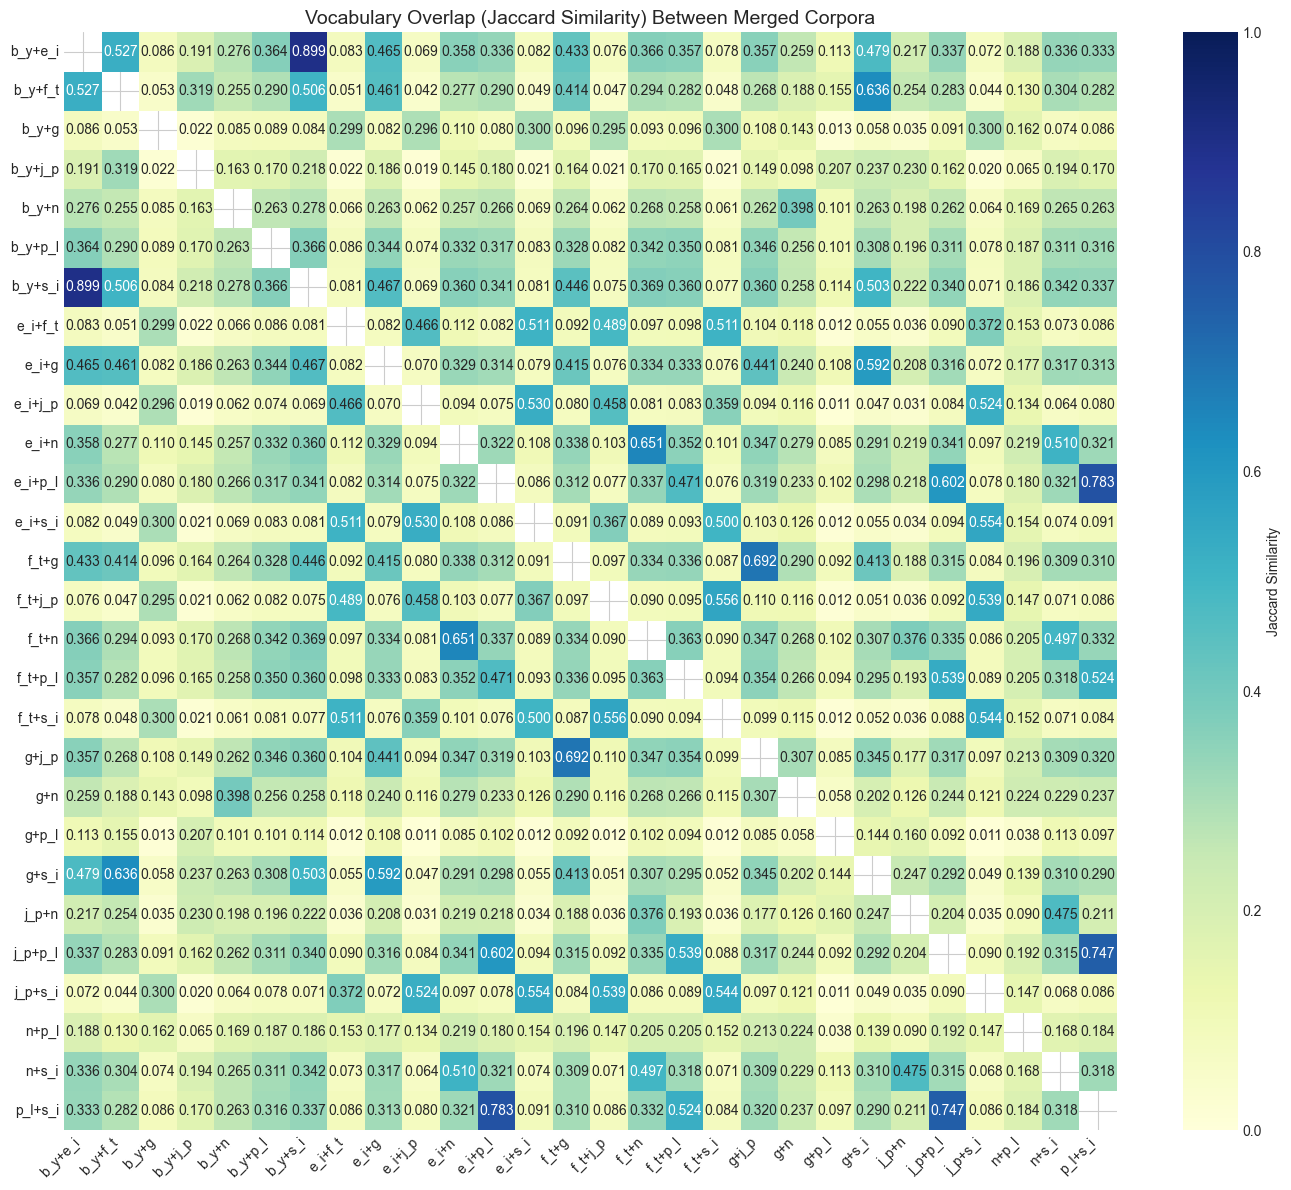


TOP 10 MOST SIMILAR CORPUS PAIRS (by vocabulary)
  b_y+e_i <-> b_y+s_i: 0.8987
  e_i+p_l <-> p_l+s_i: 0.7829
  j_p+p_l <-> p_l+s_i: 0.7466
  f_t+g <-> g+j_p: 0.6916
  e_i+n <-> f_t+n: 0.6507
  b_y+f_t <-> g+s_i: 0.6364
  e_i+p_l <-> j_p+p_l: 0.6025
  e_i+g <-> g+s_i: 0.5916
  f_t+j_p <-> f_t+s_i: 0.5558
  e_i+s_i <-> j_p+s_i: 0.5535


9

In [16]:
# ========================================
# PAIRWISE VOCABULARY SIMILARITY MATRIX
# ========================================

print("Computing pairwise vocabulary similarity (Jaccard)...")
start_time = time.time()

similarity_matrix = analyzer.compute_pairwise_similarity(tokenized_corpora, show_progress=True)

sim_time = time.time() - start_time
print(f"\n✓ Similarity matrix computed in {sim_time:.2f}s")

# Visualize similarity matrix
fig, ax = plt.subplots(figsize=(14, 12))

mask = np.eye(len(similarity_matrix), dtype=bool)
sns.heatmap(similarity_matrix, ax=ax, annot=True, fmt='.3f', 
            cmap='YlGnBu', mask=mask, vmin=0, vmax=1,
            xticklabels=similarity_matrix.columns,
            yticklabels=similarity_matrix.index,
            cbar_kws={'label': 'Jaccard Similarity'})

ax.set_title('Vocabulary Overlap (Jaccard Similarity) Between Merged Corpora', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Save and close
plt.savefig(f'{OUTPUT_DIR}/vocabulary_similarity_heatmap.png', dpi=150, bbox_inches='tight')
print(f"✓ Similarity heatmap saved to {OUTPUT_DIR}/vocabulary_similarity_heatmap.png")
plt.show()
plt.close(fig)

# Save similarity matrix
similarity_matrix.to_csv(f'{OUTPUT_DIR}/vocabulary_similarity_matrix.csv')

# Print top-10 most similar pairs
sim_pairs = []
names = list(similarity_matrix.columns)
for i in range(len(names)):
    for j in range(i+1, len(names)):
        sim_pairs.append((names[i], names[j], similarity_matrix.iloc[i, j]))

sim_pairs.sort(key=lambda x: x[2], reverse=True)

print(f"\n{'='*60}")
print("TOP 10 MOST SIMILAR CORPUS PAIRS (by vocabulary)")
print(f"{'='*60}")
for c1, c2, sim in sim_pairs[:10]:
    print(f"  {c1} <-> {c2}: {sim:.4f}")
print(f"{'='*60}")

# Save similar pairs
pd.DataFrame(sim_pairs, columns=['corpus1', 'corpus2', 'similarity']).to_csv(
    f'{OUTPUT_DIR}/corpus_similarity_pairs.csv', index=False)

del similarity_matrix, sim_pairs
gc.collect()

Analyzing distributional laws across corpora...
✓ Zipf's Law plots saved to ./outputs/zipfs_law_analysis.png
✓ Zipf's Law plots saved to ./outputs/zipfs_law_analysis.png


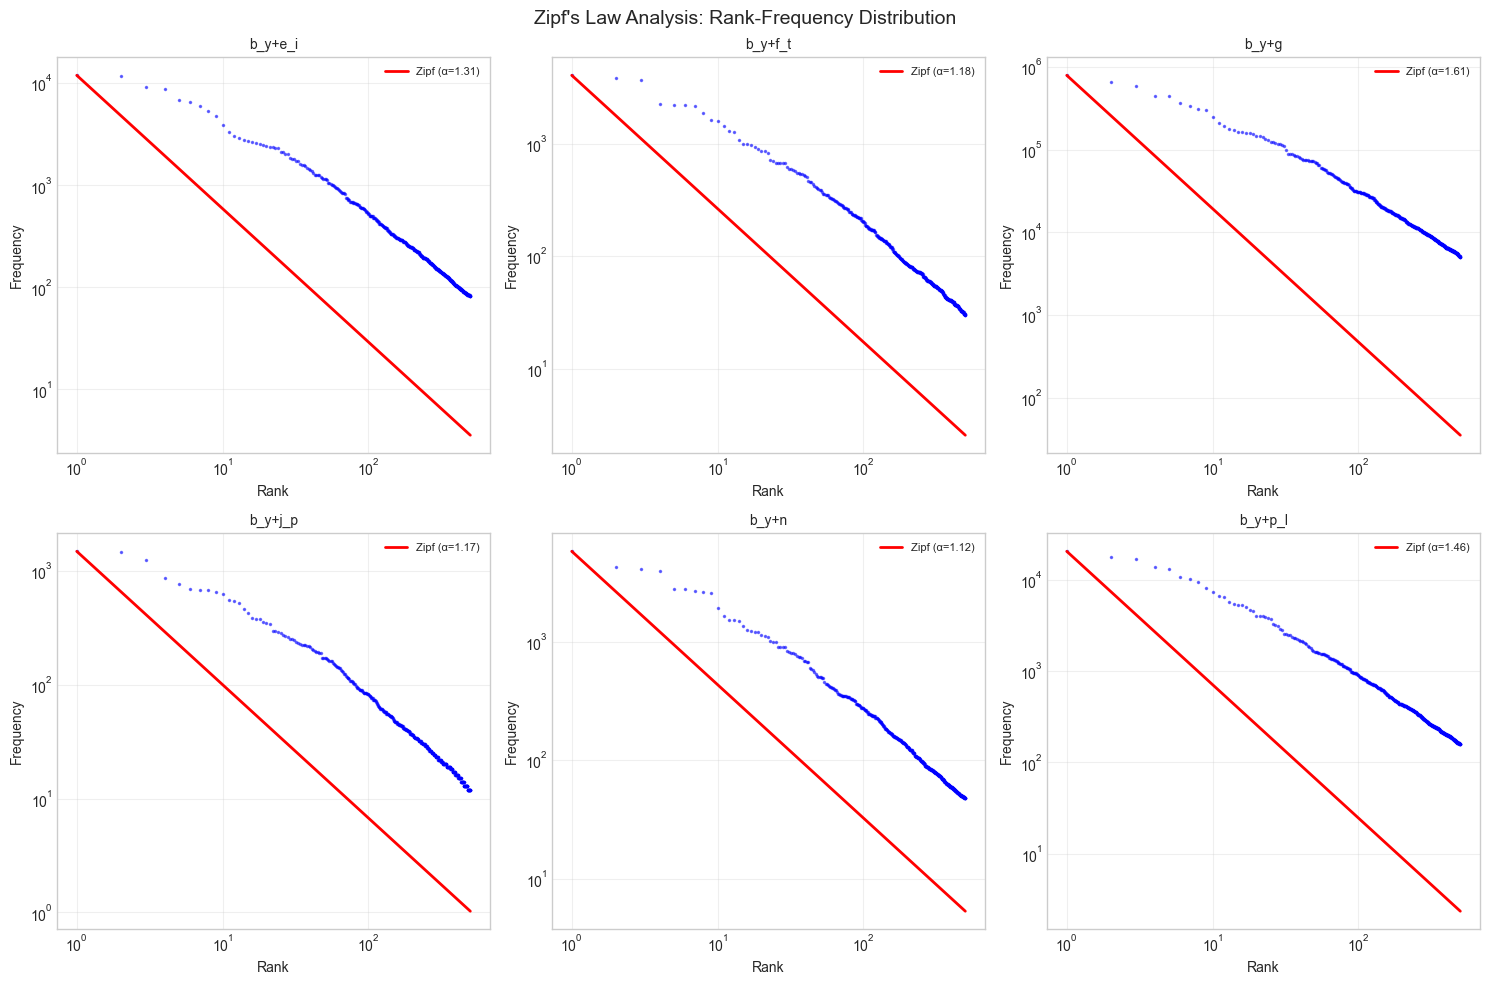


ZIPF'S LAW EXPONENTS (α) - Theoretical value ≈ 1.0
  ✓ b_y+n: α = 1.124
  ✓ b_y+j_p: α = 1.170
  ✓ b_y+f_t: α = 1.182
  ⚠ b_y+e_i: α = 1.307
  ⚠ b_y+p_l: α = 1.463
  ⚠ b_y+g: α = 1.611
  Mean α: 1.310
  Std α:  0.175


67818

In [17]:
# ========================================
# ZIPF'S LAW & HEAPS' LAW ANALYSIS
# ========================================
from utils.text_stats import zipfs_law_analysis, heaps_law_analysis

print("Analyzing distributional laws across corpora...")

# Select a few representative corpora for detailed analysis
sample_corpora = list(tokenized_corpora.keys())[:6]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

zipf_results = {}

for idx, name in enumerate(sample_corpora):
    tokens = tokenized_corpora[name]
    
    # Zipf's Law analysis
    ranks, freqs, zipf_exp = zipfs_law_analysis(tokens)
    zipf_results[name] = zipf_exp
    
    # Plot Zipf's Law (log-log)
    row, col = idx // 3, idx % 3
    ax = axes[row, col]
    
    if len(ranks) > 0:
        ax.loglog(ranks[:500], freqs[:500], 'b.', alpha=0.5, markersize=3)
        
        # Theoretical Zipf line
        theoretical = freqs[0] / (ranks[:500] ** zipf_exp)
        ax.loglog(ranks[:500], theoretical, 'r-', linewidth=2, 
                  label=f'Zipf (α={zipf_exp:.2f})')
        
    ax.set_xlabel('Rank')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{name}', fontsize=10)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle("Zipf's Law Analysis: Rank-Frequency Distribution", fontsize=14)
plt.tight_layout()

# Save and close
plt.savefig(f'{OUTPUT_DIR}/zipfs_law_analysis.png', dpi=150, bbox_inches='tight')
print(f"✓ Zipf's Law plots saved to {OUTPUT_DIR}/zipfs_law_analysis.png")
plt.show()
plt.close(fig)

# Summary statistics
print(f"\n{'='*60}")
print("ZIPF'S LAW EXPONENTS (α) - Theoretical value ≈ 1.0")
print(f"{'='*60}")
for name, exp in sorted(zipf_results.items(), key=lambda x: x[1]):
    deviation = abs(exp - 1.0)
    status = "✓" if deviation < 0.3 else "⚠"
    print(f"  {status} {name}: α = {exp:.3f}")
print(f"{'='*60}")
print(f"  Mean α: {np.mean(list(zipf_results.values())):.3f}")
print(f"  Std α:  {np.std(list(zipf_results.values())):.3f}")
print(f"{'='*60}")

# Save Zipf results
pd.DataFrame([{'corpus': k, 'zipf_exponent': v} for k, v in zipf_results.items()]).to_csv(
    f'{OUTPUT_DIR}/zipf_exponents.csv', index=False)

gc.collect()

KeyboardInterrupt: 

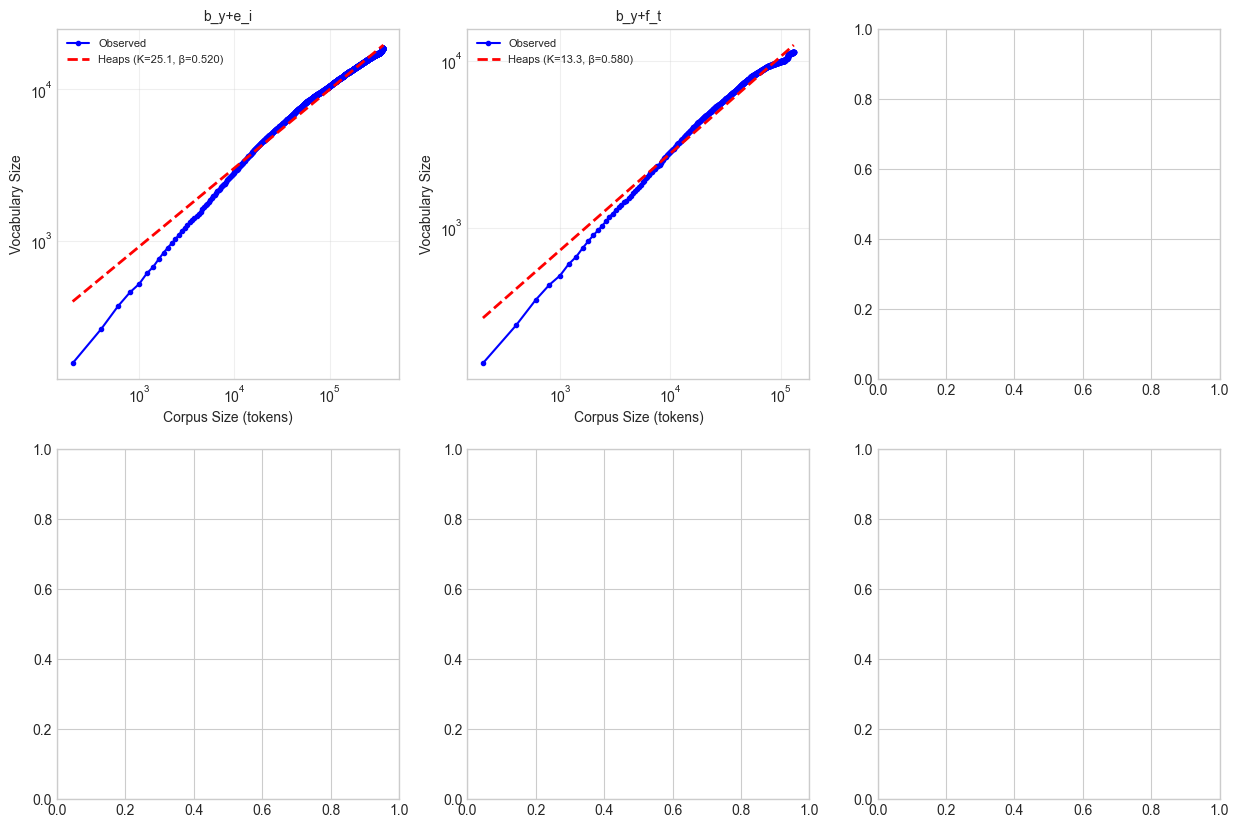

In [18]:
# ========================================
# HEAPS' LAW: VOCABULARY GROWTH ANALYSIS
# ========================================

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

heaps_results = {}

for idx, name in enumerate(sample_corpora):
    tokens = tokenized_corpora[name]
    
    # Heaps' Law analysis
    corpus_sizes, vocab_sizes, K, beta = heaps_law_analysis(tokens, step=200)
    heaps_results[name] = {'K': K, 'beta': beta}
    
    row, col = idx // 3, idx % 3
    ax = axes[row, col]
    
    if len(corpus_sizes) > 1:
        # Plot actual data
        ax.loglog(corpus_sizes, vocab_sizes, 'bo-', markersize=3, label='Observed')
        
        # Theoretical Heaps' curve: V = K * N^β
        theoretical = K * (corpus_sizes ** beta)
        ax.loglog(corpus_sizes, theoretical, 'r--', linewidth=2, 
                  label=f'Heaps (K={K:.1f}, β={beta:.3f})')
        
    ax.set_xlabel('Corpus Size (tokens)')
    ax.set_ylabel('Vocabulary Size')
    ax.set_title(f'{name}', fontsize=10)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle("Heaps' Law Analysis: Vocabulary Growth", fontsize=14)
plt.tight_layout()

# Save and close
plt.savefig(f'{OUTPUT_DIR}/heaps_law_analysis.png', dpi=150, bbox_inches='tight')
print(f"✓ Heaps' Law plots saved to {OUTPUT_DIR}/heaps_law_analysis.png")
plt.show()
plt.close(fig)

# Summary
print(f"\n{'='*60}")
print("HEAPS' LAW PARAMETERS (V = K × N^β)")
print("Typical β: 0.4-0.6 for natural language")
print(f"{'='*60}")
for name, params in heaps_results.items():
    status = "✓" if 0.3 < params['beta'] < 0.8 else "⚠"
    print(f"  {status} {name}: K={params['K']:.2f}, β={params['beta']:.3f}")
print(f"{'='*60}")

# Save Heaps results
pd.DataFrame([{'corpus': k, **v} for k, v in heaps_results.items()]).to_csv(
    f'{OUTPUT_DIR}/heaps_parameters.csv', index=False)

gc.collect()

In [19]:
# ========================================
# N-GRAM ANALYSIS: BIGRAM & TRIGRAM ENTROPY
# ========================================
from utils.nlp_metrics import compute_ngram_statistics

print("Computing n-gram statistics...")

ngram_results = []

for name, tokens in tokenized_corpora.items():
    for n in [1, 2, 3]:
        stats = compute_ngram_statistics(tokens, n=n)
        stats['corpus'] = name
        stats['n'] = n
        ngram_results.append(stats)

ngram_df = pd.DataFrame(ngram_results)

# Pivot for comparison
pivot_ttr = ngram_df.pivot(index='corpus', columns='n', values='ngram_ttr')
pivot_entropy = ngram_df.pivot(index='corpus', columns='n', values='ngram_entropy')

print(f"\n{'='*70}")
print("N-GRAM TYPE-TOKEN RATIO (TTR) BY CORPUS")
print("Higher TTR = more diverse n-gram usage")
print(f"{'='*70}")
print(pivot_ttr.round(4).to_string())
print(f"{'='*70}")

print(f"\n{'='*70}")
print("N-GRAM ENTROPY BY CORPUS (bits)")
print("Higher entropy = more unpredictable/diverse")
print(f"{'='*70}")
print(pivot_entropy.round(4).to_string())
print(f"{'='*70}")

# Save n-gram results
ngram_df.to_csv(f'{OUTPUT_DIR}/ngram_statistics.csv', index=False)
pivot_ttr.to_csv(f'{OUTPUT_DIR}/ngram_ttr_pivot.csv')
pivot_entropy.to_csv(f'{OUTPUT_DIR}/ngram_entropy_pivot.csv')
print(f"\n✓ N-gram statistics saved to {OUTPUT_DIR}/ngram_*.csv")

del ngram_results, pivot_ttr, pivot_entropy
gc.collect()

Computing n-gram statistics...
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\20232788\AppData\Local\anaconda3\envs\dbl1\Lib\site-packages\IPython\core\interactiveshell.py", line 3549, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\20232788\AppData\Local\Temp\ipykernel_19916\2072774824.py", line 12, in <module>
    stats = compute_ngram_statistics(tokens, n=n)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\20232788\Desktop\Year3\language_and_ai\jupyter_notebooks\utils\nlp_metrics.py", line 293, in compute_ngram_statistics
    'ngram_entropy': NLPMetrics.shannon_entropy([str(ng) for ng in ngrams]),
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\20232788\Desktop\Year3\language_and_ai\jupyter_notebooks\utils\nlp_metrics.py", line None, in shannon_entropy
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\20232788\AppData\Local

Computing TF-IDF with device: cuda
GPU acceleration: Enabled ✓

✓ TF-IDF computed in 156.226s
  Matrix shape: (28, 564617) (corpora × vocabulary)
  Vocabulary size: 564,617 unique terms
✓ TF-IDF heatmap saved to ./outputs/tfidf_similarity_heatmap.png


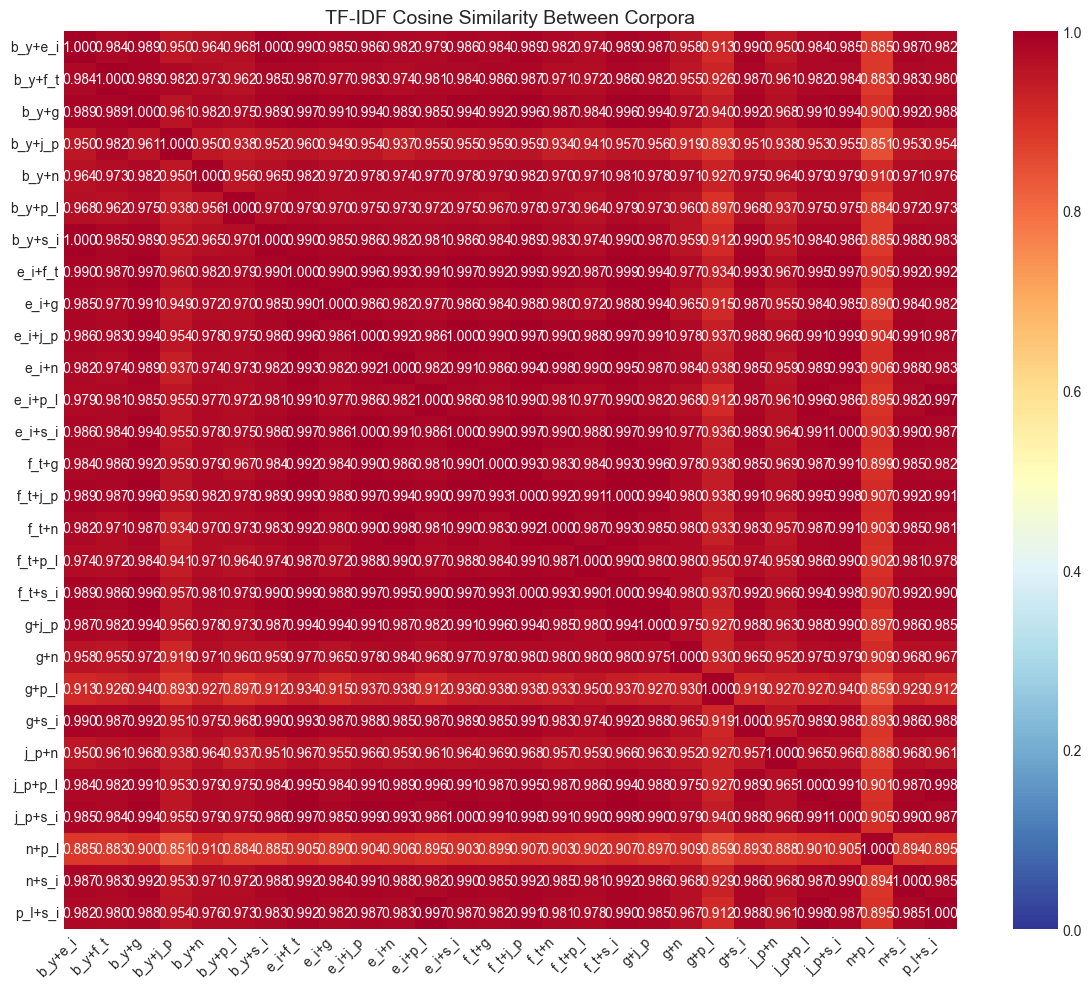

✓ TF-IDF similarity matrix saved to ./outputs/tfidf_similarity_matrix.csv


0

In [20]:
# ========================================
# GPU-ACCELERATED TF-IDF ANALYSIS (if available)
# ========================================

print(f"Computing TF-IDF with device: {gpu_analyzer.device}")
print(f"GPU acceleration: {'Enabled ✓' if gpu_analyzer.has_gpu else 'Disabled (CPU fallback)'}")

start_time = time.time()

# Get all token lists for TF-IDF
all_token_lists = list(tokenized_corpora.values())
corpus_names_ordered = list(tokenized_corpora.keys())

# Compute TF-IDF matrix
tfidf_matrix, vocab = gpu_analyzer.compute_tfidf_gpu(all_token_lists)

tfidf_time = time.time() - start_time

print(f"\n✓ TF-IDF computed in {tfidf_time:.3f}s")
print(f"  Matrix shape: {tfidf_matrix.shape} (corpora × vocabulary)")
print(f"  Vocabulary size: {len(vocab):,} unique terms")

# Compute corpus-level TF-IDF similarity
corpus_similarity = np.dot(tfidf_matrix, tfidf_matrix.T)

# Visualize
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corpus_similarity, ax=ax, annot=True, fmt='.3f',
            cmap='RdYlBu_r', vmin=0, vmax=1,
            xticklabels=corpus_names_ordered,
            yticklabels=corpus_names_ordered)
ax.set_title('TF-IDF Cosine Similarity Between Corpora', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save and close
plt.savefig(f'{OUTPUT_DIR}/tfidf_similarity_heatmap.png', dpi=150, bbox_inches='tight')
print(f"✓ TF-IDF heatmap saved to {OUTPUT_DIR}/tfidf_similarity_heatmap.png")
plt.show()
plt.close(fig)

# Save TF-IDF similarity matrix
tfidf_sim_df = pd.DataFrame(corpus_similarity, index=corpus_names_ordered, columns=corpus_names_ordered)
tfidf_sim_df.to_csv(f'{OUTPUT_DIR}/tfidf_similarity_matrix.csv')
print(f"✓ TF-IDF similarity matrix saved to {OUTPUT_DIR}/tfidf_similarity_matrix.csv")

# Clear large matrices
del tfidf_matrix, corpus_similarity, vocab, all_token_lists, tfidf_sim_df
gc.collect()

In [ ]:
# ========================================
# STATISTICAL SUMMARY: NLP METRICS BY ORIGINAL DF PAIRING
# ========================================

# Link corpus stats back to original dataframe pairs
def get_original_dfs_from_key(key: str) -> Tuple[str, str]:
    """Parse merged key to get original df names."""
    parts = key.split('+')
    df1_name, df2_name = None, None
    for name in dataframes_dict.keys():
        init = _initials(name)
        if init == parts[0]:
            df1_name = name
        elif init == parts[1]:
            df2_name = name
    return df1_name, df2_name

# Build enhanced stats dataframe
enhanced_stats = corpus_stats_df.copy()
enhanced_stats['df1'] = [get_original_dfs_from_key(k)[0] for k in enhanced_stats.index]
enhanced_stats['df2'] = [get_original_dfs_from_key(k)[1] for k in enhanced_stats.index]
enhanced_stats['merged_rows'] = [len(merged_dfs[k]) for k in enhanced_stats.index]

# Aggregate by involvement of each original df
print(f"{'='*80}")
print("NLP METRICS AGGREGATED BY ORIGINAL DATASET INVOLVEMENT")
print(f"{'='*80}\n")

aggregated_stats = []
for orig_df in dataframes_dict.keys():
    # Find all merges involving this df
    involved_mask = (enhanced_stats['df1'] == orig_df) | (enhanced_stats['df2'] == orig_df)
    involved_stats = enhanced_stats[involved_mask]
    
    if len(involved_stats) > 0:
        stats_row = {
            'dataset': orig_df,
            'original_size': len(dataframes_dict[orig_df]),
            'n_merged_corpora': len(involved_stats),
            'mean_ttr': involved_stats['ttr'].mean(),
            'mean_entropy': involved_stats['entropy'].mean(),
            'mean_perplexity': involved_stats['perplexity'].mean(),
            'mean_yules_k': involved_stats['yules_k'].mean()
        }
        aggregated_stats.append(stats_row)
        
        print(f"{orig_df} (original size: {len(dataframes_dict[orig_df]):,})")
        print(f"   Appears in {len(involved_stats)} merged corpora")
        print(f"   Mean TTR:        {involved_stats['ttr'].mean():.4f}")
        print(f"   Mean entropy:    {involved_stats['entropy'].mean():.2f} bits")
        print(f"   Mean perplexity: {involved_stats['perplexity'].mean():.1f}")
        print(f"   Mean Yule's K:   {involved_stats['yules_k'].mean():.2f}")
        print()

print(f"{'='*80}")

# Save aggregated stats
pd.DataFrame(aggregated_stats).to_csv(f'{OUTPUT_DIR}/aggregated_nlp_by_dataset.csv', index=False)
print(f"✓ Aggregated stats saved to {OUTPUT_DIR}/aggregated_nlp_by_dataset.csv")

In [ ]:
# ========================================
# CORRELATION ANALYSIS: NLP Metrics vs Merge Properties
# ========================================

# Add merge properties to enhanced stats
enhanced_stats['log_merged_rows'] = np.log10(enhanced_stats['merged_rows'] + 1)

# Select numeric columns for correlation
metric_cols = ['n_tokens', 'vocab_size', 'ttr', 'root_ttr', 'hapax_ratio',
               'yules_k', 'simpsons_d', 'entropy', 'norm_entropy', 
               'perplexity', 'avg_word_len', 'log_merged_rows']

corr_matrix = enhanced_stats[metric_cols].corr()

# Visualize
fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, ax=ax, mask=mask, annot=True, fmt='.2f',
            cmap='RdBu_r', vmin=-1, vmax=1, center=0,
            square=True, linewidths=0.5)
ax.set_title('Correlation Matrix: NLP Metrics', fontsize=14)
plt.tight_layout()

# Save and close
plt.savefig(f'{OUTPUT_DIR}/nlp_metrics_correlation.png', dpi=150, bbox_inches='tight')
print(f"✓ Correlation heatmap saved to {OUTPUT_DIR}/nlp_metrics_correlation.png")
plt.show()
plt.close(fig)

# Save correlation matrix
corr_matrix.to_csv(f'{OUTPUT_DIR}/nlp_metrics_correlation.csv')

# Key correlations with merged size
print(f"\n{'='*60}")
print("CORRELATIONS WITH MERGED DATASET SIZE")
print(f"{'='*60}")
size_corrs = corr_matrix['log_merged_rows'].drop('log_merged_rows').sort_values(key=abs, ascending=False)
for metric, corr in size_corrs.items():
    strength = "strong" if abs(corr) > 0.5 else "moderate" if abs(corr) > 0.3 else "weak"
    direction = "+" if corr > 0 else "-"
    print(f"  {metric:20} r = {corr:+.3f} ({strength} {direction})")
print(f"{'='*60}")

del corr_matrix
gc.collect()

In [ ]:
# ========================================
# FINAL SUMMARY: COMPREHENSIVE NLP STATISTICS TABLE
# ========================================

# Create final summary table with all key metrics
summary_table = enhanced_stats[[
    'df1', 'df2', 'merged_rows', 'n_tokens', 'vocab_size',
    'ttr', 'hapax_ratio', 'yules_k', 'simpsons_d', 
    'entropy', 'perplexity', 'avg_word_len'
]].copy()

summary_table = summary_table.rename(columns={
    'merged_rows': 'Merged Rows',
    'n_tokens': 'Tokens (sampled)',
    'vocab_size': 'Vocabulary',
    'ttr': 'TTR',
    'hapax_ratio': 'Hapax Ratio',
    'yules_k': "Yule's K",
    'simpsons_d': "Simpson's D",
    'entropy': 'Entropy (bits)',
    'perplexity': 'Perplexity',
    'avg_word_len': 'Avg Word Len'
})

# Sort by entropy (linguistic complexity proxy)
summary_table = summary_table.sort_values('Entropy (bits)', ascending=False)

print("="*100)
print("COMPREHENSIVE NLP STATISTICS FOR ALL MERGED DATASET PAIRS")
print("="*100)
print("\nInterpretation Guide:")
print("  • TTR (Type-Token Ratio): Higher = more lexical diversity")
print("  • Hapax Ratio: Proportion of words appearing exactly once")
print("  • Yule's K: Lower = richer vocabulary (typically 20-200)")
print("  • Simpson's D: Higher = more diversity (0-1 scale)")
print("  • Entropy: Information content in bits (higher = more unpredictable)")
print("  • Perplexity: Exponential of entropy (lower = more predictable)")
print("="*100)
print()

# Display formatted table
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
print(summary_table.round(4).to_string())

# Save final summary
summary_table.to_csv(f'{OUTPUT_DIR}/final_nlp_summary.csv')

print("\n" + "="*100)
print(f"✓ Analysis complete. All results saved to {OUTPUT_DIR}/")
print("="*100)

# Final cleanup - clear tokenized corpora to free significant memory
del tokenized_corpora, enhanced_stats, summary_table
gc.collect()

# List all saved files
print(f"\n Saved files in {OUTPUT_DIR}/:")
for f in sorted(os.listdir(OUTPUT_DIR)):
    size_kb = os.path.getsize(f'{OUTPUT_DIR}/{f}') / 1024
    print(f"   {f}: {size_kb:.1f} KB")